<a href="https://colab.research.google.com/github/eshansurendra/EN3160_Assignment_03/blob/main/A03_E01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Surendra SAJE
## 210625H
## Github - https://github.com/eshansurendra/EN3160_Assignment_03

# Task 01

## Data Loading

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 50
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:05<00:00, 30.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Excution of Given Code

In [ ]:
# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases
w = torch.randn(Din, K) * std  # One layer: directly map input to output
b = torch.zeros(K)

# Hyperparameters
iterations = 20
lr = 2e-6  # Learning rate
lr_decay = 0.9  # Learning rate decay
reg = 0  # Regularization
loss_history = []

In [ ]:
# 3. Training Loop
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float()  # Convert labels to one-hot encoding

        # Forward pass
        y_pred = x_train.mm(w) + b  # Output layer activation

        # Loss calculation (Mean Squared Error with regularization)
        loss = (1 / Ntr) * torch.sum((y_pred - y_train_onehot) ** 2) + reg * torch.sum(w ** 2)
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = (2.0 / Ntr) * (y_pred - y_train_onehot)
        dw = x_train.t().mm(dy_pred) + reg * w
        db = dy_pred.sum(dim=0)

        # Parameter update
        w -= lr * dw
        b -= lr * db

    # Print loss for every epoch
    if t % 1 == 0:
        print(f"Epoch {t + 1}/{iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

Epoch 1/20, Loss: 0.9769043758511543
Epoch 2/20, Loss: 0.9497961527109147
Epoch 3/20, Loss: 0.9360628283023834
Epoch 4/20, Loss: 0.9275166453123093
Epoch 5/20, Loss: 0.921580497264862
Epoch 6/20, Loss: 0.9171807104945183
Epoch 7/20, Loss: 0.9137706848978996
Epoch 8/20, Loss: 0.9110454742312432
Epoch 9/20, Loss: 0.9088170107603073
Epoch 10/20, Loss: 0.906965440273285
Epoch 11/20, Loss: 0.905406108379364
Epoch 12/20, Loss: 0.9040795442461967
Epoch 13/20, Loss: 0.902941223859787
Epoch 14/20, Loss: 0.9019580183029174
Epoch 15/20, Loss: 0.9011046329140663
Epoch 16/20, Loss: 0.9003598331212997
Epoch 17/20, Loss: 0.8997073381543159
Epoch 18/20, Loss: 0.8991339325904846
Epoch 19/20, Loss: 0.8986285871267319
Epoch 20/20, Loss: 0.8981822453737259


### Results

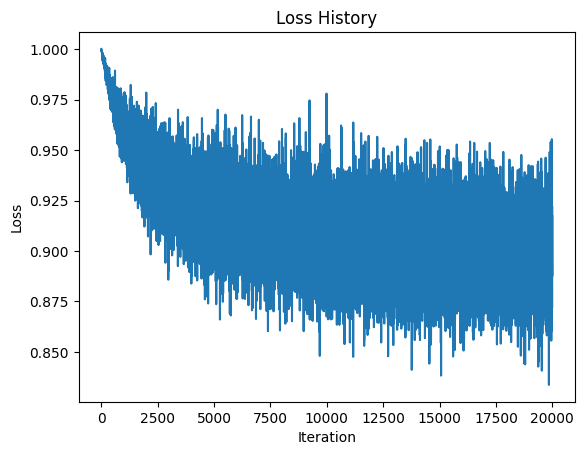

In [ ]:
# 4. Plotting the Loss History
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
# 5. Calculate Accuracy on Training Set
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)

        # Forward pass
        y_train_pred = x_train.mm(w) + b
        predicted_train = torch.argmax(y_train_pred, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

train_acc = 100 * correct_train / total_train
print(f"Training accuracy: {train_acc:.2f}%")

# 6. Calculate Accuracy on Test Set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)

        # Forward pass
        y_test_pred = x_test.mm(w) + b
        predicted_test = torch.argmax(y_test_pred, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

test_acc = 100 * correct_test / total_test
print(f"Test accuracy: {test_acc:.2f}%")


Training accuracy: 32.21%
Test accuracy: 32.40%


## Modified code with hidden layer

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Check if GPU is available and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Dataloading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 50
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
H = 100  # Number of nodes in hidden layer
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases for both layers and move them to the GPU
w1 = torch.randn(Din, H, device=device) * std  # Input to hidden layer weights
b1 = torch.zeros(H, device=device)
w2 = torch.randn(H, K, device=device) * std  # Hidden to output layer weights
b2 = torch.zeros(K, device=device)

# Hyperparameters
epochs = 10
lr = 1e-3  # Learning rate
lr_decay = 0.9  # Learning rate decay
reg = 0  # Regularization
loss_history = []

# Define cross-entropy loss function
def cross_entropy_loss(y_pred, y_true):
    return -torch.sum(y_true * torch.log(y_pred + 1e-9)) / y_true.shape[0]

# Sigmoid Activation Function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


# 3. Training Loop
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels and move them to the GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float() # Convert labels to one-hot encoding

        # Forward pass: Layer 1
        hidden_layer = torch.sigmoid(x_train.mm(w1) + b1)

        # Forward pass: Layer 2 (output layer)
        y_pred = torch.softmax(hidden_layer.mm(w2) + b2, dim = 1)  # Output layer activation

        # Loss calculation (Cross-Entropy Loss with regularization)
        loss = cross_entropy_loss(y_pred, y_train_onehot) + reg * (torch.sum(w1**2) + torch.sum(w2**2))
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = y_pred - y_train_onehot
        dw2 = hidden_layer.t().mm(dy_pred) + reg * w2
        db2 = dy_pred.sum(dim=0)
        dhidden = dy_pred.mm(w2.t()) * hidden_layer * (1 - hidden_layer)
        dw1 = x_train.t().mm(dhidden) + reg * w1
        db1 = dhidden.sum(dim=0)

        # Parameter update
        w1 -= lr * dw1
        b1 -= lr * db1
        w2 -= lr * dw2
        b2 -= lr * db2

    # Print loss for every epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay


Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 2.157187548160553
Epoch 2/10, Loss: 1.901293078303337
Epoch 3/10, Loss: 1.8041703002452851
Epoch 4/10, Loss: 1.74914091026783
Epoch 5/10, Loss: 1.7110346133708954
Epoch 6/10, Loss: 1.682911412715912
Epoch 7/10, Loss: 1.660356973052025
Epoch 8/10, Loss: 1.6409922444820404
Epoch 9/10, Loss: 1.624794057369232
Epoch 10/10, Loss: 1.610462854385376


### Results

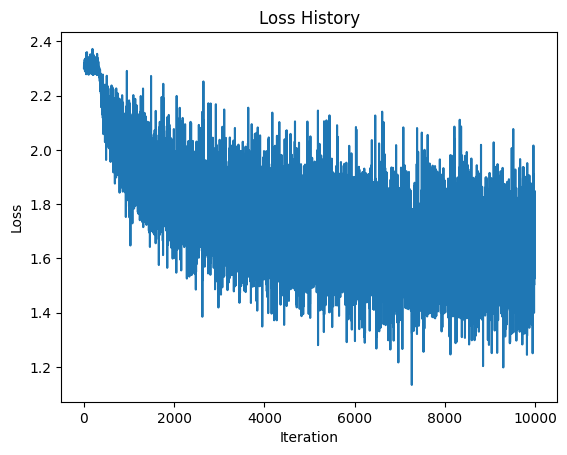

In [ ]:
# 4. Plotting the Loss History
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
# 5. Calculate Accuracy on Training Set
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)

        # Forward pass
        hidden_output = sigmoid(x_train.mm(w1) + b1)
        y_train_pred = torch.softmax(hidden_output.mm(w2) + b2, dim=1)
        predicted_train = torch.argmax(y_train_pred, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

train_acc = 100 * correct_train / total_train
print(f"Training accuracy: {train_acc:.2f}%")

# 6. Calculate Accuracy on Test Set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)

        # Forward pass
        hidden_output = sigmoid(x_test.mm(w1) + b1)
        y_test_pred = torch.softmax(hidden_output.mm(w2) + b2, dim=1)
        predicted_test = torch.argmax(y_test_pred, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

test_acc = 100 * correct_test / total_test
print(f"Test accuracy: {test_acc:.2f}%")

Training accuracy: 44.91%
Test accuracy: 44.01%


## Combined approch to plot loss and accuracies over epoches

Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 2.1532041409015656, Training Accuracy: 17.57%
Test Accuracy: 26.47%
Epoch 2/10, Loss: 1.8998437217473985, Training Accuracy: 31.04%
Test Accuracy: 35.20%
Epoch 3/10, Loss: 1.8048883595466614, Training Accuracy: 35.93%
Test Accuracy: 37.48%
Epoch 4/10, Loss: 1.748351583838463, Training Accuracy: 38.21%
Test Accuracy: 39.29%
Epoch 5/10, Loss: 1.710121345758438, Training Accuracy: 40.07%
Test Accuracy: 40.72%
Epoch 6/10, Loss: 1.6830106012821198, Training Accuracy: 41.16%
Test Accuracy: 41.51%
Epoch 7/10, Loss: 1.6618051459789276, Training Accuracy: 42.19%
Test Accuracy: 42.34%
Epoch 8/10, Loss: 1.6440168641805648, Training Accuracy: 42.94%
Test Accuracy: 43.04%
Epoch 9/10, Loss: 1.6277331380844116, Training Accuracy: 43.49%
Test Accuracy: 43.28%
Epoch 10/10, Loss: 1.6141222558021546, Training Accuracy: 44.11%
Test Accuracy: 43.04%


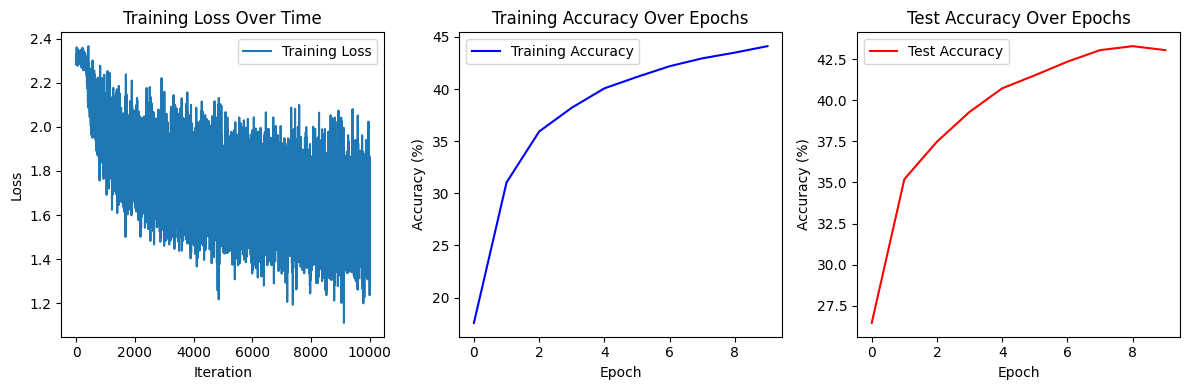

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Check if GPU is available and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Dataloading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 50
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
H = 100  # Number of nodes in hidden layer
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases for both layers and move them to the GPU
w1 = torch.randn(Din, H, device=device) * std  # Input to hidden layer weights
b1 = torch.zeros(H, device=device)
w2 = torch.randn(H, K, device=device) * std  # Hidden to output layer weights
b2 = torch.zeros(K, device=device)

# Hyperparameters
epochs = 10
lr = 1e-3  # Learning rate
lr_decay = 0.9  # Learning rate decay
reg = 0  # Regularization
loss_history = []
train_acc_history = []
test_acc_history = []

# Define cross-entropy loss function
def cross_entropy_loss(y_pred, y_true):
    return -torch.sum(y_true * torch.log(y_pred + 1e-9)) / y_true.shape[0]

# Sigmoid Activation Function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


# 3. Training Loop
for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels and move them to the GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float() # Convert labels to one-hot encoding

        # Forward pass: Layer 1
        hidden_layer = torch.sigmoid(x_train.mm(w1) + b1)

        # Forward pass: Layer 2 (output layer)
        y_pred = torch.softmax(hidden_layer.mm(w2) + b2, dim=1)  # Output layer activation

        # Loss calculation (Cross-Entropy Loss with regularization)
        loss = cross_entropy_loss(y_pred, y_train_onehot) + reg * (torch.sum(w1**2) + torch.sum(w2**2))
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = y_pred - y_train_onehot
        dw2 = hidden_layer.t().mm(dy_pred) + reg * w2
        db2 = dy_pred.sum(dim=0)
        dhidden = dy_pred.mm(w2.t()) * hidden_layer * (1 - hidden_layer)
        dw1 = x_train.t().mm(dhidden) + reg * w1
        db1 = dhidden.sum(dim=0)

        # Parameter update
        w1 -= lr * dw1
        b1 -= lr * db1
        w2 -= lr * dw2
        b2 -= lr * db2

        # Calculate training accuracy for the batch
        predicted_train = torch.argmax(y_pred, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    # Calculate and store accuracy for the entire epoch
    train_acc = 100 * correct_train / total_train
    train_acc_history.append(train_acc)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(trainloader)}, Training Accuracy: {train_acc:.2f}%")

    # Learning rate decay
    lr *= lr_decay

    # Calculate test accuracy for the epoch
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            Nte = inputs.shape[0]
            x_test = inputs.view(Nte, -1)

            # Forward pass
            hidden_output = sigmoid(x_test.mm(w1) + b1)
            y_test_pred = torch.softmax(hidden_output.mm(w2) + b2, dim=1)
            predicted_test = torch.argmax(y_test_pred, dim=1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_acc_history.append(test_acc)
    print(f"Test Accuracy: {test_acc:.2f}%")

# Plotting the loss, training, and test accuracy over epochs
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()

# Training accuracy plot
plt.subplot(1, 3, 2)
plt.plot(train_acc_history, label="Training Accuracy", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Over Epochs")
plt.legend()

# Test accuracy plot
plt.subplot(1, 3, 3)
plt.plot(test_acc_history, label="Test Accuracy", color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

## Results and Discussion

### Initial Network Performance (Without Hidden Layer)
- **Epochs**: 20
- **Loss Progression**:
  - Epoch 1: Loss = 0.9769
  - Epoch 10: Loss = 0.9069
  - Epoch 20: Loss = 0.8982
- **Training Accuracy**: 32.21%
- **Testing Accuracy**: 32.40%

---

### Modified Network Performance (With Hidden Layer and Cross-Entropy Loss)
- **Epochs**: 10
- **Loss Progression**:
  - Epoch 1: Loss = 2.1532
  - Epoch 5: Loss = 1.7101
  - Epoch 10: Loss = 1.6141
- **Training Accuracy**: 44.91%
- **Testing Accuracy**: 44.01%

---

### Discussion

The results demonstrate that adding a hidden layer with 100 nodes and applying cross-entropy loss significantly improved the network’s performance:

1. **Loss Reduction**:
   - In the initial network, the loss steadily decreased over 20 epochs but remained relatively high, indicating limited capacity for capturing complex data patterns.
   - With the added hidden layer, the model achieved a more substantial loss reduction, suggesting that the increased network depth enabled it to learn more effectively.

2. **Accuracy Improvement**:
   - The training accuracy increased from 32.21% to 44.91%, and the testing accuracy from 32.40% to 44.01%.
   - This improvement suggests that the additional layer allowed the network to learn more expressive representations, leading to better performance on both the training and test sets.

3. **Training Dynamics**:
   - With similar training and testing accuracies, the model shows signs of generalization rather than overfitting.
   - However, with only 10 epochs, there may still be room for improvement if training is continued for more epochs, as the loss was still decreasing by the end.


## Optinal Run on 30 epoches to observe behaviour

Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30, Loss: 2.16040072953701, Training Accuracy: 16.64%
Test Accuracy: 25.80%
Epoch 2/30, Loss: 1.908185378909111, Training Accuracy: 30.59%
Test Accuracy: 33.91%
Epoch 3/30, Loss: 1.8073394700288772, Training Accuracy: 35.95%
Test Accuracy: 37.26%
Epoch 4/30, Loss: 1.74900448179245, Training Accuracy: 38.17%
Test Accuracy: 38.37%
Epoch 5/30, Loss: 1.710159280538559, Training Accuracy: 39.84%
Test Accuracy: 40.39%
Epoch 6/30, Loss: 1.681552660703659, Training Accuracy: 41.19%
Test Accuracy: 41.12%
Epoch 7/30, Loss: 1.6588073350191117, Training Accuracy: 42.29%
Test Accuracy: 42.26%
Epoch 8/30, Loss: 1.639461492538452, Training Accuracy: 42.89%
Test Accuracy: 42.42%
Epoch 9/30, Loss: 1.6239333703517913, Training Accuracy: 43.64%
Test Accuracy: 42.92%
Epoch 10/30, Loss: 1.6095789794921875, Training Accuracy: 43.99%
Test Accuracy: 43.36%
Epoch 11/30, Loss: 1.5979018893241883, Training Ac

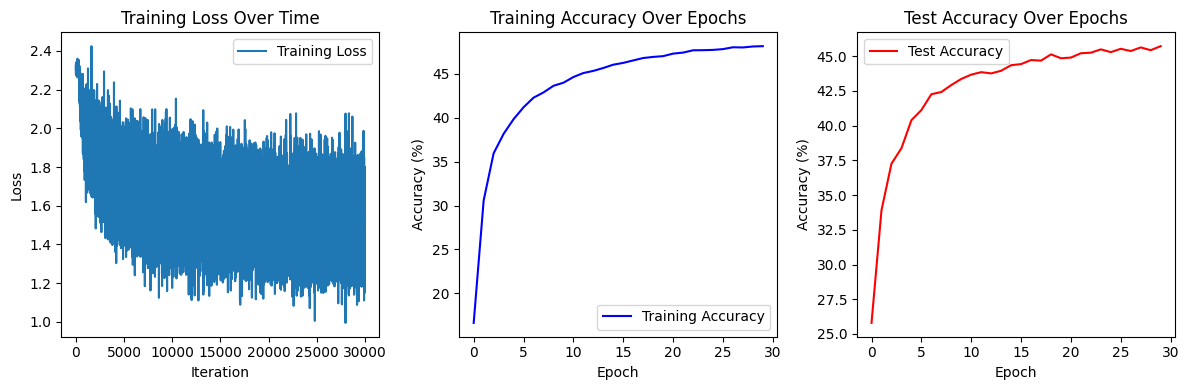

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Check if GPU is available and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Dataloading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 50
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
H = 100  # Number of nodes in hidden layer
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases for both layers and move them to the GPU
w1 = torch.randn(Din, H, device=device) * std  # Input to hidden layer weights
b1 = torch.zeros(H, device=device)
w2 = torch.randn(H, K, device=device) * std  # Hidden to output layer weights
b2 = torch.zeros(K, device=device)

# Hyperparameters
epochs = 30
lr = 1e-3  # Learning rate
lr_decay = 0.9  # Learning rate decay
reg = 0  # Regularization
loss_history = []
train_acc_history = []
test_acc_history = []

# Define cross-entropy loss function
def cross_entropy_loss(y_pred, y_true):
    return -torch.sum(y_true * torch.log(y_pred + 1e-9)) / y_true.shape[0]

# Sigmoid Activation Function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


# 3. Training Loop
for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels and move them to the GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float() # Convert labels to one-hot encoding

        # Forward pass: Layer 1
        hidden_layer = torch.sigmoid(x_train.mm(w1) + b1)

        # Forward pass: Layer 2 (output layer)
        y_pred = torch.softmax(hidden_layer.mm(w2) + b2, dim=1)  # Output layer activation

        # Loss calculation (Cross-Entropy Loss with regularization)
        loss = cross_entropy_loss(y_pred, y_train_onehot) + reg * (torch.sum(w1**2) + torch.sum(w2**2))
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = y_pred - y_train_onehot
        dw2 = hidden_layer.t().mm(dy_pred) + reg * w2
        db2 = dy_pred.sum(dim=0)
        dhidden = dy_pred.mm(w2.t()) * hidden_layer * (1 - hidden_layer)
        dw1 = x_train.t().mm(dhidden) + reg * w1
        db1 = dhidden.sum(dim=0)

        # Parameter update
        w1 -= lr * dw1
        b1 -= lr * db1
        w2 -= lr * dw2
        b2 -= lr * db2

        # Calculate training accuracy for the batch
        predicted_train = torch.argmax(y_pred, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    # Calculate and store accuracy for the entire epoch
    train_acc = 100 * correct_train / total_train
    train_acc_history.append(train_acc)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(trainloader)}, Training Accuracy: {train_acc:.2f}%")

    # Learning rate decay
    lr *= lr_decay

    # Calculate test accuracy for the epoch
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            Nte = inputs.shape[0]
            x_test = inputs.view(Nte, -1)

            # Forward pass
            hidden_output = sigmoid(x_test.mm(w1) + b1)
            y_test_pred = torch.softmax(hidden_output.mm(w2) + b2, dim=1)
            predicted_test = torch.argmax(y_test_pred, dim=1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_acc_history.append(test_acc)
    print(f"Test Accuracy: {test_acc:.2f}%")

# Plotting the loss, training, and test accuracy over epochs
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()

# Training accuracy plot
plt.subplot(1, 3, 2)
plt.plot(train_acc_history, label="Training Accuracy", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Over Epochs")
plt.legend()

# Test accuracy plot
plt.subplot(1, 3, 3)
plt.plot(test_acc_history, label="Test Accuracy", color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()